#Install Dependencies and Import Libraries

In [ ]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.metrics import r2_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

!pip install dice-ml
import dice_ml

!pip install lime
import lime
import lime.lime_tabular

!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 7.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283838 sha256=e97f761157837a259294a6094d168c327af192d728c719f381d2c9bcae8e5de4
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.0 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#Inherently Interpretable Modeling: Linear Regression
We are going to start our demonstration with linear regression and analyzing model weights. We will compare these results with LASSO regression and decision tree regression.

##Loading Bike Rental Dataset
This benchmark regression problem has several input features:


1.   Year (Numerical)
2.   Temperature (Numerical)
3.   Humidity (Numerical)
4.   Wind Speed (Numerical)
5.   Days Since 1/1/2011 (Numerical)
6.   Season (Categorical)
7.   Month (Categorical)
8.   Holiday (Categorical)
9.   Weekday (Categorical)
10.  Working Day (Categorical)
11.  Weather Condition (Categorical)

Given these features, we want to predict the daily number of bike rentals. Let's begin with loading the training set into a pandas dataframe:

In [ ]:
# Read data from URL from raw github source
df = pd.read_csv('https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv')

# Encoding categorical variables (k-1 features for a feature with k categories)
df = pd.get_dummies(df, drop_first=True, prefix_sep='=')

df['yr'] = df['yr'] - 2011 # slight correction for scaling purposes

# Obtain y (regression target labels: count of daily bike rentals)
y = df['cnt']

# Obtain rest of feature values
x = df.drop(columns=['cnt'])


,yr,temp,hum,windspeed,days_since_2011,season=SPRING,season=SUMMER,season=WINTER,mnth=AUG,mnth=DEC,...,holiday=NO HOLIDAY,weekday=MON,weekday=SAT,weekday=SUN,weekday=THU,weekday=TUE,weekday=WED,workingday=WORKING DAY,weathersit=MISTY,weathersit=RAIN/SNOW/STORM
0,0,8.175849,80.5833,10.749882,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,1,0
1,0,9.083466,69.6087,16.652113,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
2,0,1.229108,43.7273,16.636703,2,0,0,1,0,0,...,1,1,0,0,0,0,0,1,0,0
3,0,1.400000,59.0435,10.739832,3,0,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0
4,0,2.666979,43.6957,12.522300,4,0,0,1,0,0,...,1,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,3.945849,65.2917,23.458911,726,0,0,1,0,1,...,1,0,0,0,1,0,0,1,1,0
727,1,3.906651,59.0000,10.416557,727,0,0,1,0,1,...,1,0,0,0,0,0,0,1,1,0
728,1,3.906651,75.2917,8.333661,728,0,0,1,0,1,...,1,0,1,0,0,0,0,0,1,0
729,1,4.024151,48.3333,23.500518,729,0,0,1,0,1,...,1,0,0,1,0,0,0,0,0,0


We can immediately observe that we now have 29 features, with most of them being categorical! We will first try a naive approach: ordinary least squares regression. Using statsmodels, we can easily implement this in a matter of just a few lines of code. With this implementation, we will also be able to recover the standard error of each coefficient, allowing us to obtain 95% confidence intervals for each model parameter!

In [ ]:
# Split dataset into 80%-20% training-testing split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# OLS linear regression model with intercept term
# add_constant is necessary as statsmodels OLS by default will not include intercept term
x_train_sm = sm.add_constant(x_train)
x_test_sm = sm.add_constant(x_test)

# Define and train model
linear_regressor = sm.OLS(y_train, x_train_sm)
results = linear_regressor.fit()

# Use model parameters from results to predict the test set
yhat_test = linear_regressor.predict(results.params, x_test_sm)

# Report testing performance measures
test_rmse = np.sqrt(np.mean( yhat_test - y_test  ) ** 2)
test_r2score = r2_score(y_test, yhat_test)

print('Test RMSE: {}'.format(test_rmse))
print('Test R2 Score: {}'.format(test_r2score))

Test RMSE: 21.334215450710982
Test R2 Score: 0.8429385201818678


## Visualizing OLS Result
Before we evaluate our performance on the testing set, let's examine the training performance more closely. Ideally, for a linear regression model, the residuals (y - yhat) should be somewhat normally distributed around a mean of 0. We will also visualize results with a parity plot: ideally results should be distributed along a 45 degree line from the origin.

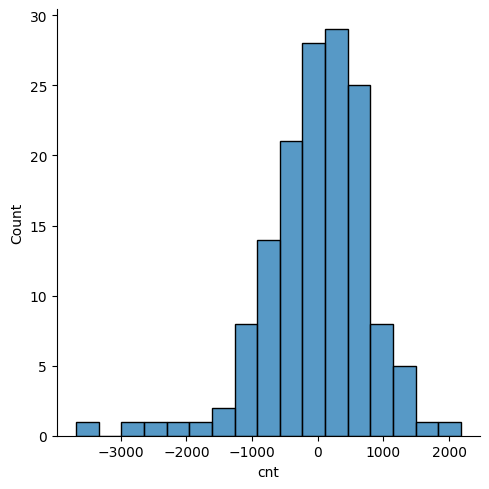

In [ ]:
sns.displot(y_test - yhat_test)

Text(0, 0.5, 'Actual y')

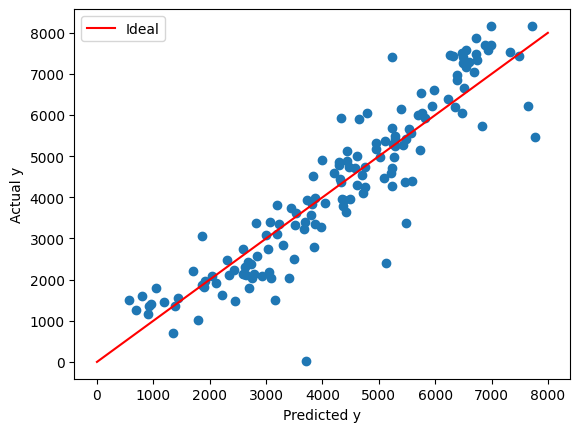

In [ ]:
plt.scatter(yhat_test, y_test)
plt.plot(np.arange(8000), np.arange(8000), label='Ideal', color='red')
plt.legend()
plt.xlabel('Predicted y')
plt.ylabel('Actual y')

Based on the above results, do you find the OLS model reliable? Why or why not? We will continue on with visualizing the weight estimates:

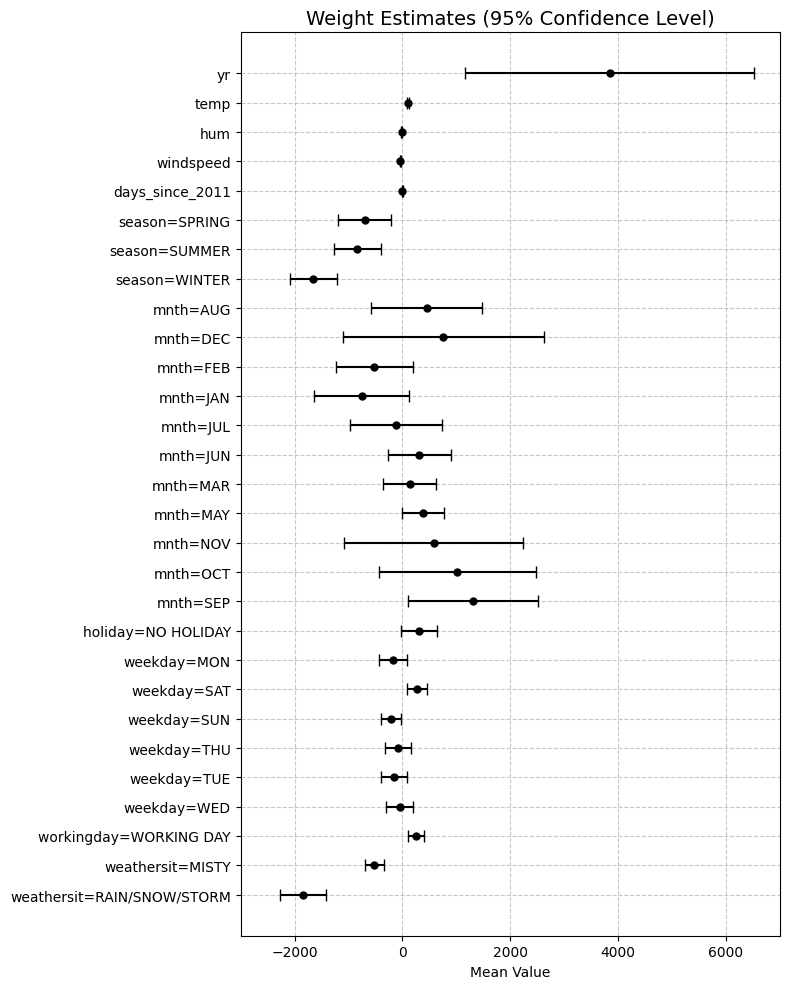

In [ ]:
feature_names = list(x.columns)
mean_values = results.params[1:] # Mean coefficients for non-intercept terms
error_values = 2*results.bse[1:] # 2x the standard error for ~95% confidence intervals for non-intercept terms

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8,10))

# Plot the horizontal errorbar chart
y_pos = feature_names
ax.errorbar(mean_values, y_pos, xerr=error_values, fmt='o', markersize=5, capsize=4, color='black')

# Set y-axis labels and tick positions
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names, fontsize=10)
ax.invert_yaxis()  # Invert the y-axis to list features from top to bottom

# Set x-axis label and limits
ax.set_xlabel('Mean Value')
ax.set_xlim(-3000, 7000)  # Adjusting xaxis range

# Add a grid to the plot
ax.grid(axis='both', linestyle='--', alpha=0.7)

# Add a title
plt.title('Weight Estimates (95% Confidence Level)', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


The effects of each feature are better understood when we multiply the (mean) weights with the feature values. Let's visualize feature effects with boxplots. This will look quite different for numerical vs categorical features.

In [ ]:
feature_effects = x_test  * results.params[1:]
feature_effects

,yr,temp,hum,windspeed,days_since_2011,season=SPRING,season=SUMMER,season=WINTER,mnth=AUG,mnth=DEC,...,holiday=NO HOLIDAY,weekday=MON,weekday=SAT,weekday=SUN,weekday=THU,weekday=TUE,weekday=WED,workingday=WORKING DAY,weathersit=MISTY,weathersit=RAIN/SNOW/STORM
703,3845.333123,1492.256935,-1017.117552,-458.037041,-3584.938106,-0.000000,-0.00000,-0.000000,0.0,755.85749,...,313.878957,-0.000000,0.0000,-0.00000,-0.000000,-155.982367,-0.00000,256.075867,-0.000000,-0.0
33,0.000000,81.757347,-606.910404,-730.611812,-168.283012,-0.000000,-0.00000,-1654.066482,0.0,0.00000,...,313.878957,-0.000000,0.0000,-0.00000,-77.595946,-0.000000,-0.00000,256.075867,-0.000000,-0.0
300,0.000000,784.263054,-812.076357,-603.632262,-1529.845564,-0.000000,-0.00000,-0.000000,0.0,0.00000,...,313.878957,-0.000000,0.0000,-0.00000,-0.000000,-0.000000,-0.00000,256.075867,-518.903301,-0.0
456,3845.333123,1248.121114,-937.411577,-453.139150,-2325.365258,-699.495428,-0.00000,-0.000000,0.0,0.00000,...,313.878957,-0.000000,0.0000,-214.50911,-0.000000,-0.000000,-0.00000,0.000000,-518.903301,-0.0
633,3845.333123,1854.393364,-790.128797,-621.629778,-3227.974141,-0.000000,-0.00000,-0.000000,0.0,0.00000,...,313.878957,-0.000000,0.0000,-0.00000,-0.000000,-155.982367,-0.00000,256.075867,-0.000000,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.000000,776.128449,-824.205527,-580.736855,-356.963965,-0.000000,-0.00000,-1654.066482,0.0,0.00000,...,313.878957,-0.000000,272.3122,-0.00000,-0.000000,-0.000000,-0.00000,0.000000,-0.000000,-0.0
192,0.000000,3046.591585,-775.112191,-526.757459,-979.101161,-0.000000,-833.14359,-0.000000,0.0,0.00000,...,313.878957,-0.000000,0.0000,-0.00000,-0.000000,-155.982367,-0.00000,256.075867,-0.000000,-0.0
328,0.000000,999.917990,-892.360373,-260.140124,-1672.631150,-0.000000,-0.00000,-0.000000,0.0,0.00000,...,313.878957,-0.000000,0.0000,-0.00000,-0.000000,-0.000000,-0.00000,256.075867,-0.000000,-0.0
165,0.000000,2228.736584,-653.820490,-441.683554,-841.415060,-699.495428,-0.00000,-0.000000,0.0,0.00000,...,313.878957,-0.000000,0.0000,-0.00000,-0.000000,-0.000000,-49.86386,256.075867,-0.000000,-0.0


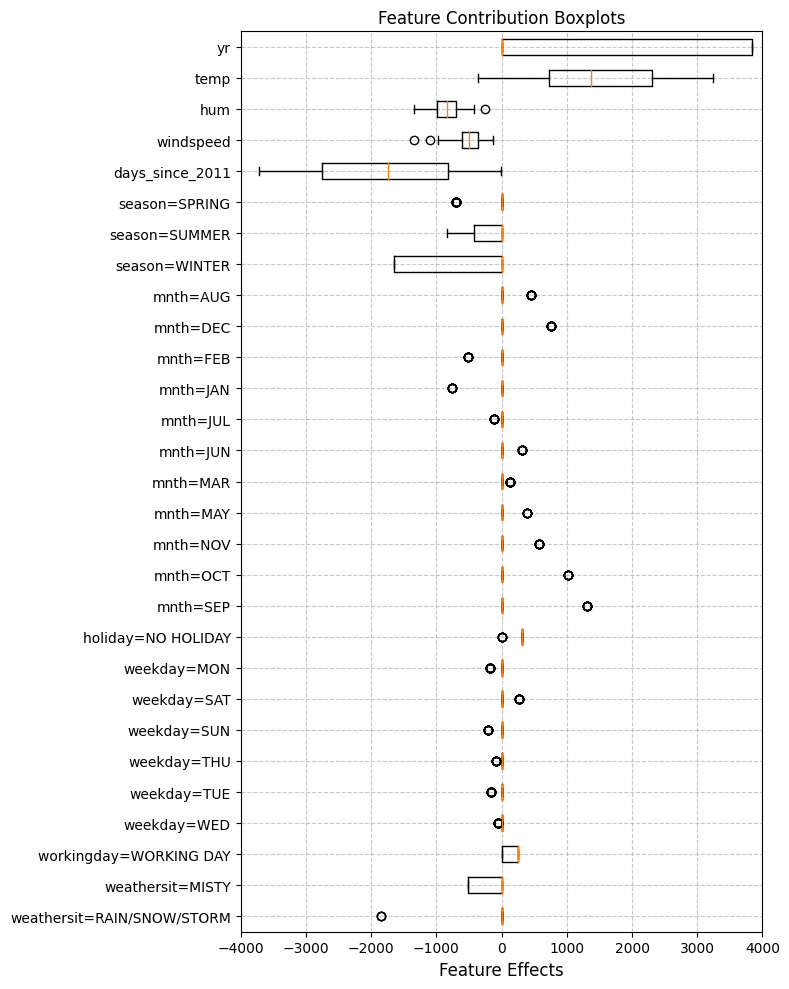

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 10))

# Plot the horizontal box-and-whisker plot
bplot = ax.boxplot(feature_effects, vert=False)

# Set y-axis labels and tick positions
ax.set_yticks(np.arange(1, len(feature_names) + 1))
ax.set_yticklabels(feature_names, fontsize=10)
ax.invert_yaxis()

# Set x-axis label and limits
ax.set_xlabel('Feature Effects', fontsize=12)
ax.set_xlim(-4000, 4000)

# Add a grid to the plot
ax.grid(axis='both', linestyle='--', alpha=0.7)

# Add a title
ax.set_title('Feature Contribution Boxplots')

# Show the plot
plt.tight_layout()
plt.show()


## LASSO Regression
Let's repeat the above steps with LASSO regression, with varying settings for the regularization parameter α (referred to in the slides as λ). This time, instead of using statsmodels, we will use scikit-learn's LASSO implementation.

In [ ]:
# Define and train model
lasso_regressor = Lasso(alpha=2000, fit_intercept=True, max_iter=3000)
lasso_regressor.fit(x_train, y_train)

# Use model parameters to predict the test set
yhat_test = lasso_regressor.predict(x_test)

# Report testing performance measures
test_rmse = np.sqrt(np.mean( yhat_test - y_test  ) ** 2)
test_r2score = r2_score(y_test, yhat_test)

print('Test RMSE: {}'.format(test_rmse))
print('Test R2 Score: {}'.format(test_r2score))

Test RMSE: 83.47125555116367
Test R2 Score: 0.7016974010488235


In [ ]:
# Weights of LASSO model accessible here:
lasso_regressor.coef_

array([  0.        ,  96.86855117, -12.18133646,  -0.        ,
         5.09930359,   0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,   0.        ,   0.        ,   0.        ,
        -0.        ,   0.        ,   0.        ,   0.        ,
        -0.        ,   0.        ,  -0.        ,   0.        ,
        -0.        ,   0.        ,   0.        ,  -0.        ,
        -0.        ])

While the RMSE is improved, the model is not very sparse. In fact, under this parameter setting, only 1 feature value is 0! Should we regularize this model further? What are the pros and cons?

TO DO: Pick 6 values of the regularization parameter α and plot the number of non-zero terms as a function of the regularization parameter. Here is some starter code:

In [ ]:
alpha_list = [1e-1, 1e0, 1e1, 25, 50, 1e2 ] # populate with 6 values
num_nonzero_terms_list = [] # populate in each iteration

for alpha_val in alpha_list:
  lasso_regressor = Lasso(alpha=alpha_val, fit_intercept=True, max_iter=3000)
  lasso_regressor.fit(x_train, y_train)

  num_nonzero_terms_list.append(np.sum(lasso_regressor.coef_ != 0))  # TODO: calculate nonzero terms

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.132e+07, tolerance: 2.141e+05


Which features tend to be zeroed out in your sparse models? How do the weights and feature effects compare with the previous OLS result? Hint: reference the feature_names variable.

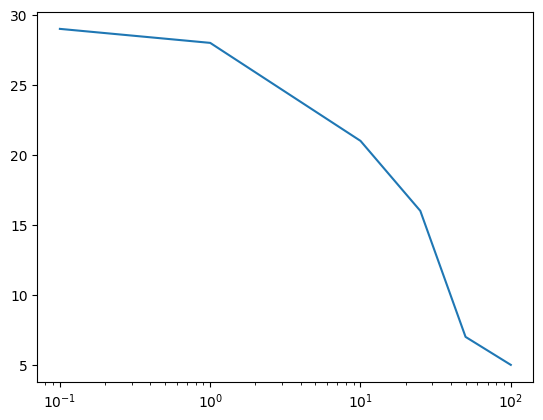

In [ ]:
plt.semilogx(alpha_list, num_nonzero_terms_list)

In [ ]:
lasso_regressor.coef_

array([  0.        ,  96.86855117, -12.18133646,  -0.        ,
         5.09930359,   0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,   0.        ,   0.        ,   0.        ,
        -0.        ,   0.        ,   0.        ,   0.        ,
        -0.        ,   0.        ,  -0.        ,   0.        ,
        -0.        ,   0.        ,   0.        ,  -0.        ,
        -0.        ])

In [ ]:
feature_names

['yr',
 'temp',
 'hum',
 'windspeed',
 'days_since_2011',
 'season=SPRING',
 'season=SUMMER',
 'season=WINTER',
 'mnth=AUG',
 'mnth=DEC',
 'mnth=FEB',
 'mnth=JAN',
 'mnth=JUL',
 'mnth=JUN',
 'mnth=MAR',
 'mnth=MAY',
 'mnth=NOV',
 'mnth=OCT',
 'mnth=SEP',
 'holiday=NO HOLIDAY',
 'weekday=MON',
 'weekday=SAT',
 'weekday=SUN',
 'weekday=THU',
 'weekday=TUE',
 'weekday=WED',
 'workingday=WORKING DAY',
 'weathersit=MISTY',
 'weathersit=RAIN/SNOW/STORM']

# Inherently Interpretable Modeling: Decision Trees
We will use decision tree regression to compare results with the previous linear regression models, as well as compare the interpretations. For implementation, we will utilize scikit-learn's DecisionTreeRegressor class. For the sake of interpretability, we will restrict the maximum depth of the tree.

In [ ]:
# Define and train model
dt_regressor = DecisionTreeRegressor(max_depth=3)
dt_regressor.fit(x_train, y_train)

# Use model parameters to predict the test set
yhat_train = dt_regressor.predict(x_train)

# Report testing performance measures
test_rmse = np.sqrt(np.mean( yhat_train - y_train  ) ** 2)
test_r2score = r2_score(y_train, yhat_train)

print('Test RMSE: {}'.format(test_rmse))
print('Test R2 Score: {}'.format(test_r2score))

Train RMSE: 3.426178671062401e-14
Train R2 Score: 0.8040582148478821


How does the generalization performance on the testing set compare to the previous models? Furthermore, how does the decision tree model perform on the testing set compared to the training set?

TO DO: What evidence can we acquire for overtraining or undertraining?

To interpret feature contributions, let's begin with plotting the trained decision tree model. scikit-learn's helpful plot_tree utility function is helpful with this. The built-in feature_importances_ also summarizes which features contributed most to the decision tree regressor's splits.

[Text(0.5, 0.875, 'days_since_2011 <= 430.0\nsquared_error = 3665701.549\nsamples = 584\nvalue = 4560.978'),
 Text(0.25, 0.625, 'days_since_2011 <= 105.5\nsquared_error = 1712327.683\nsamples = 339\nvalue = 3455.655'),
 Text(0.125, 0.375, 'days_since_2011 <= 69.5\nsquared_error = 499387.475\nsamples = 78\nvalue = 1744.577'),
 Text(0.0625, 0.125, 'squared_error = 251470.714\nsamples = 54\nvalue = 1447.093'),
 Text(0.1875, 0.125, 'squared_error = 410066.41\nsamples = 24\nvalue = 2413.917'),
 Text(0.375, 0.375, 'temp <= 13.914\nsquared_error = 938358.916\nsamples = 261\nvalue = 3967.011'),
 Text(0.3125, 0.125, 'squared_error = 755804.086\nsamples = 110\nvalue = 3325.518'),
 Text(0.4375, 0.125, 'squared_error = 553186.259\nsamples = 151\nvalue = 4434.325'),
 Text(0.75, 0.625, 'temp <= 11.662\nsquared_error = 2338963.273\nsamples = 245\nvalue = 6090.384'),
 Text(0.625, 0.375, 'days_since_2011 <= 720.5\nsquared_error = 2564397.086\nsamples = 59\nvalue = 4343.288'),
 Text(0.5625, 0.125, 'squa

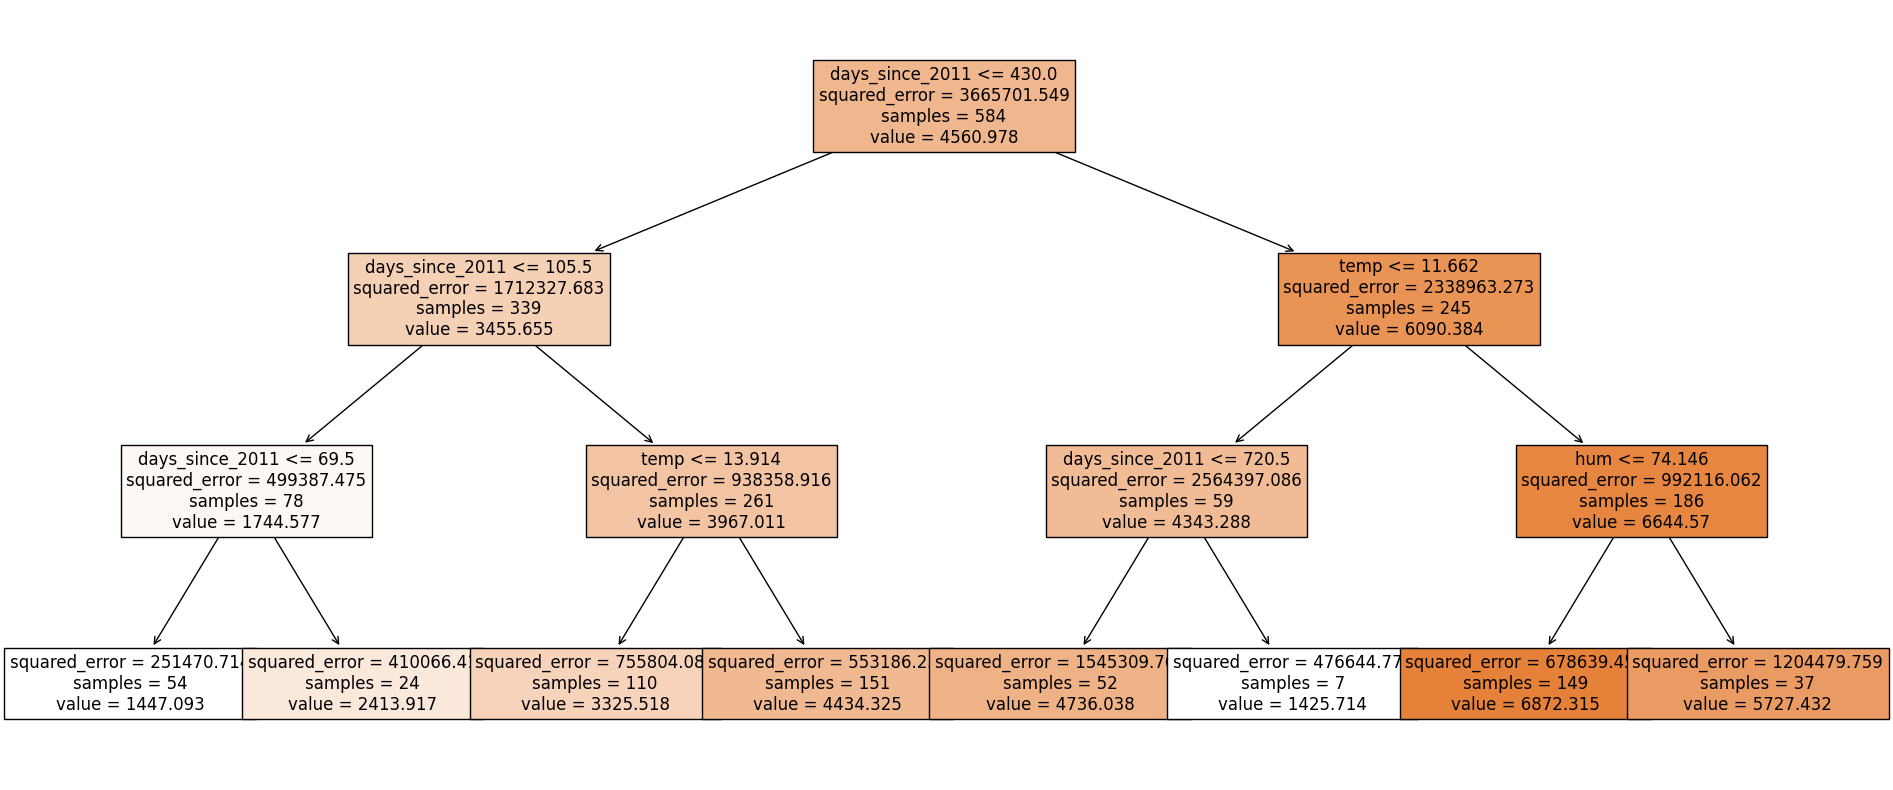

In [ ]:
plt.figure(figsize=(24,10))
plot_tree(dt_regressor, feature_names=feature_names, fontsize=12, filled=True)

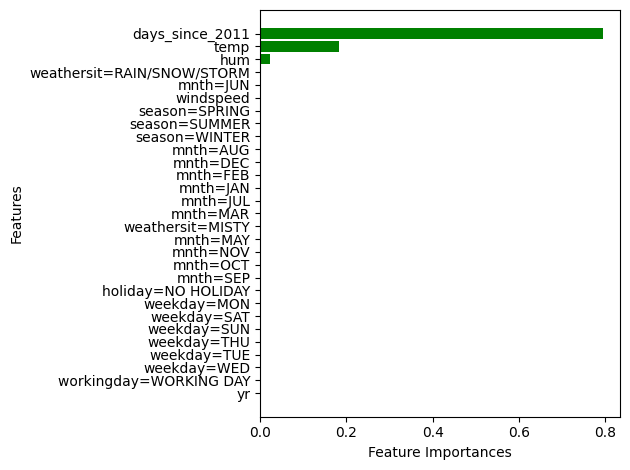

In [ ]:
feature_importances = dt_regressor.feature_importances_

# Sort so that when we plot the feature importances, the largest are on top
sorted_indices = np.argsort(feature_importances)
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array([feature_names[i] for i in sorted_indices])

# Create horizontal bar chart
plt.barh(sorted_feature_names, sorted_feature_importances, color='green')
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Only 3 features were used to construct this tree! This ended up being a sparse regressor dominated by the temporal trend (days_since_2011).

If we went back to the LASSO model and tuned α such that we had only 3 non-zero terms, are the same features selected? How does the regression performance compare under similar levels of sparsity?

# Anomaly Detection

We will use a different dataset for anomaly detection. The MNIST dataset is a classic benchmark of 28x28 handwritten digit images, conventionally used for supervised learning algorithms.

While it is possible to achieve very high accuracy with state-of-the-art supervised classification algorithms, this dataset remains nontrivial for unsupervised tasks. Without supervision, it is easy for a computer to incorrectly group the following digits together:

*   "3" vs "8"
*   "1" or "2" vs "7"
*   "4" vs "9"

<b>We can turn MNIST into an anomaly detection problem by focusing on one of these subsets</b>. With this being a high-dimensional problem as far as XAI techniques are concerned (784 total dimensions), we want to accomplish the following goals:

1. Reduce dimenensionality with PCA
2. Use same principal components for anomaly scoring
3. Be able to obtain explanations for anomaly predictions

Let's begin with loading the dataset. To make sure we've done this right, let's plot 5 digits at random.

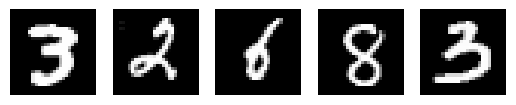

In [ ]:
# Load CSV into train and test dataframes
mnist_train = pd.read_csv('sample_data/mnist_train_small.csv')
mnist_test = pd.read_csv('sample_data/mnist_test.csv')

# Labels in the first column from each dataframe; convert to numpy arrays
y_train = np.array(mnist_train.iloc[:,0])
y_test = np.array(mnist_test.iloc[:, 0])

# Rest of the columns are pixel intensities; convert to numpy arrays
x_train = np.array(mnist_train.iloc[:, 1:])
x_test = np.array(mnist_test.iloc[:, 1:])

# Plot 5 random handwritten digits from training set
random_idxs = np.random.randint(0, len(x_train), size=5)

fig, axes = plt.subplots(1, 5)
for i, ax in enumerate(axes.flat):
  ax.imshow(x_train[random_idxs[i]].reshape((28, 28)), cmap='gray')
  ax.axis('off')

Suppose we want to do a one-class anomaly classifier to distinguish between 2 (the dominant inlier class) and 7 (outlier class). We can make this extra challenging by ensuring an extreme class imbalance (even supervised learning algorithms could struggle with this!) For our anomaly detection set-up, let's do the following:

1. Take all 2s in the training set
2. Corrupt training set with 20 samples of "7" from the testing set

In [ ]:
# Define inliers and outliers
# CHALLENGE (for later): repeat with different inlier/outlier definitions
inlier_digit = 2
outlier_digit = 7

# Take all inliers from training set
normal_idxs = np.where(y_train == inlier_digit)[0]
print('The number of inliers in our subset: {}'.format(len(normal_idxs)))

# Take the first 20 "outliers" from the testing set
abnormal_idxs = np.where(y_test == outlier_digit)[0][:20]

x_train_subset = x_train[normal_idxs, :]
x_test_subset = x_test[abnormal_idxs, :]

print('Size of total subset: {}'.format(len(normal_idxs) + len(abnormal_idxs)))
print('Anomaly Percentage: {:.2f}%'.format(100*len(abnormal_idxs) / len(normal_idxs)))

The number of inliers in our subset: 1989
Size of total subset: 2009
Anomaly Percentage: 1.01%


## Unsupervised Anomaly Detection: PCA Scoring and One-Class SVMs
In the unsupervised case, we are going to mix the subsets together and see if we can identify anomalies autonomously. Once we concatenate the arrays, we then can continue with the dimensionality reduction implemented by scikit-learn's PCA class. We will initially do a full PCA, plot the eigenvalues, and then truncate to 20 variance-maximizing dimensions.

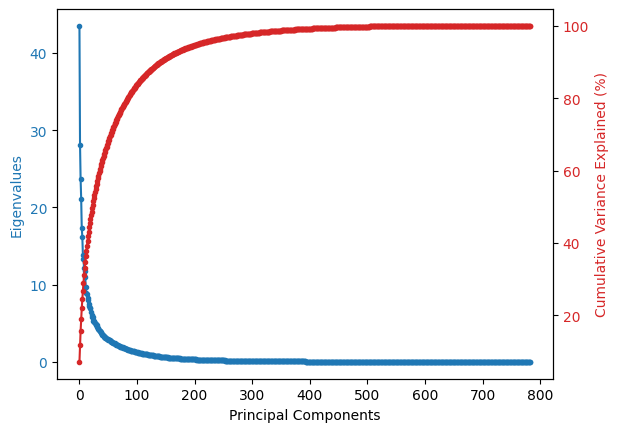

In [ ]:
# Prepare subsets for unsupervised anomaly detection & validation
x = np.concatenate([x_train_subset, x_test_subset])
y = np.concatenate([np.zeros(len(x_train_subset)), np.ones(len(x_test_subset))])

# IMPORTANT: Scale each feature before applying PCA
stdscaler = StandardScaler()
x_std = stdscaler.fit_transform(x)

# PCA model
pca_model = PCA(n_components=None) # will keep all 784 dimensions for now
x_pca = pca_model.fit_transform(x_std)

# Obtain eigenvalues: recall that they are ordered from greatest to least
# Each eigenvalue accounts for a certain amount of variance in the total set
pca_eigs = pca_model.explained_variance_

# We are going to plot the eigenvalues as well as cumulative variance explained in the same plot
# Start with eigenvalues (monotonically decreasing)
fig, ax1 = plt.subplots()
ax1.plot(pca_eigs, marker='.', color='tab:blue', label='Eigenvalues')
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Eigenvalues', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot cumulative variance explained on the second y-axis
ax2.plot(100*np.cumsum(pca_model.explained_variance_ratio_), marker='.', color='tab:red', label='Cumulative Variance Explained')
ax2.set_ylabel('Cumulative Variance Explained (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

Let's compute the anomaly scores for this unsupervised setting with just 20 principal components. According to the above plot, this explains less than 60% of the total variance! Recall the PCA anomaly scoring formula:

$$ \sum \limits_{i=1}^p \dfrac{y_i^2}{\lambda_i} = \dfrac{y_1 ^2}{\lambda_1} + \dfrac{y_2 ^2}{\lambda_2} + \dots + \dfrac{y_p ^2}{\lambda_p}$$

Using this formula, we will view the top 10 anomalies. It can be difficult in practice to set a threshold on anomaly scores--we will plot receiver operating characteristic (ROC) curves and compare performance across all possible thresholds. The area under the ROC curve (AUROC) metric is a common metric used to evaluate the performance of the classifier averaged across all thresholds.

Using ROC curves, we will also compare PCA anomaly scoring vs one-class SVMs. We will use the same 30 principal components as input to the SVMs.

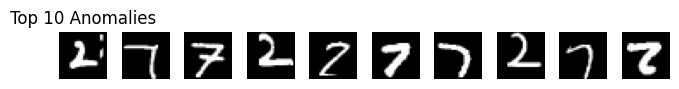

In [ ]:
# PCA Model (feel free to change number of components)
pca_model = PCA(n_components=20)
x_pca = pca_model.fit_transform(x_std)

# Obtain anomaly scores from formula above
# The higher the score, the more anomalous
anomaly_scores = np.sum( (x_pca ** 2) / pca_model.explained_variance_, axis=1)

# Sort anomaly scores and identify top 10 anomalies
anomaly_idxs = np.argsort(anomaly_scores)[::-1][:10]

# Plot top 10 anomalies according to PCA-based scoring
fig, axes = plt.subplots(1, 10)
axes[0].set_title('Top 10 Anomalies')
for i, ax in enumerate(axes.flat):
  ax.imshow(x[anomaly_idxs[i]].reshape((28, 28)), cmap='gray')
  ax.axis('off')
plt.tight_layout()

# Get ROC info (will plot after repeating with one-class SVM)
fpr_unsupervised_pca, tpr_unsupervised_pca, _ = roc_curve(y, anomaly_scores, pos_label=1)
auc_unsupervised_pca = roc_auc_score(y, anomaly_scores)

Text(0.5, 1.0, 'Unsupervised Anomaly Detection')

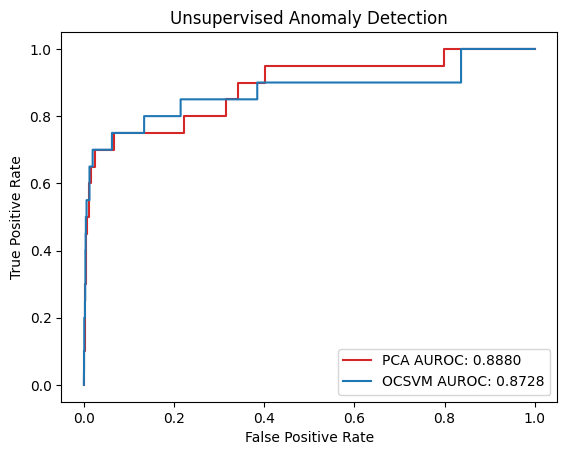

In [ ]:
# Define and train OCSVM - feel free to change kernel function and nu
ocsvm_model = OneClassSVM(kernel='rbf', nu=0.1)
ocsvm_model.fit(x_pca)

# Obtain distances from hyperplane (negative for outliers) ==> analog for PCA scores
# Important to note the negation on the ocsvm scores
ocsvm_scores = ocsvm_model.decision_function(x_pca)
fpr_unsupervised_ocsvm, tpr_unsupervised_ocsvm, _ = roc_curve(y, -ocsvm_scores, pos_label=1)
auc_unsupervised_ocsvm = roc_auc_score(y, -ocsvm_scores)

# Plot ROC curves for unsupervised anomaly detection
plt.plot(fpr_unsupervised_pca, tpr_unsupervised_pca, label='PCA AUROC: {:.4f}'.format(auc_unsupervised_pca), color='tab:red')
plt.plot(fpr_unsupervised_ocsvm, tpr_unsupervised_ocsvm, label='OCSVM AUROC: {:.4f}'.format(auc_unsupervised_ocsvm), color='tab:blue')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Unsupervised Anomaly Detection')

The above plot shows that we are reasonably successful in predicting anomalies in a fully unsupervised setting. Both methods are quite comparable at this task.

Can you improve unsupervised anomaly detection results by changing the number of principal components? How does changing the kernel function and nu parameter impact the one-class SVM results?

CHALLENGE: Repeat for other challenging anomaly detection tasks (e.g. predict the outlier 8s amongst the dominant inlier 3s) -- which unsupervised anomaly detection task is most difficult?

# Counterfactual Explanations

Next, we will employ some XAI tools to help interpret our one-class SVM model and its principal component input variables as they correspond to this anomaly detection task. While we may have been able to obtain satisfactory anomaly detection performance, it is still unclear how the principal component variables are influencing our predictions.

In this section, we will continue to work with the MNIST set from the above anomaly detection exercise. This portion will assume that the inlier/outlier digits are 2 and 7, respectively. Please rerun the cells from the previous portion if this is no longer the case. In this section, we will generate counterfactual explanations for a detected anomaly "7" to identify possible changes to produce an inlier "2". For the purpose of this demo, we will call this our **query instance**.

For this scenarios, we are asking: which principal component values need to change, and by how much, to produce a different outcome? We will use DiCE (Diverse Counterfactual Explanations) for counterfactual implementation on Python. We will begin by plotting our query instance, and visualize how it looks reconstructed after inverting the PCA+standardization so that we can have a baseline visualization to contextualize the counterfactuals we obtain.

Text(0.5, 1.0, 'Reconstructed')

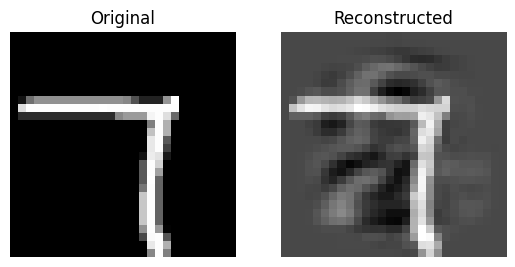

In [ ]:
# Plot Query Instance
query_idx = 2008
fig, ax = plt.subplots(1, 2)
query_original = x[query_idx].reshape((28,28))

ax[0].imshow(query_original, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original')

# Invoke inverse transform methods - this is a representation of the information that the anomaly detection model "sees"
# should resemble a low resolution version of the original input
query_std = pca_model.inverse_transform(x_pca[query_idx].reshape(1,-1))
query_reconstructed = stdscaler.inverse_transform(query_std).reshape((28,28))

ax[1].imshow(query_reconstructed, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Reconstructed')

In [ ]:
# Write into input x and outcome y into dataframes to prepare for DiCE
# Ground truth outcomes dataframe: 0 for inliers, +1 for outliers
outcome_df = pd.DataFrame(data=y, columns=['outcome'])

# Input PCA dataframe: feature names are numbered PCs in order
feature_names = ['PC_{}'.format(i+1) for i in range(np.size(x_pca, 1))]
pca_df = pd.DataFrame(data=x_pca, columns=feature_names)

# Get SVM predictions
y_pred = ocsvm_model.predict(x_pca)

# Map such that 0 is for inliers, and 1 (positive class) is for anomalies
y_pred = np.array([0 if a == 1 else 1 for a in y_pred])

# We need to obtain class probabilities for DiCE to work
# OCSVM does not do this out-of-the-box, so we will fit a logistic regression on top so that DiCE can use class probabilities
lr = LogisticRegressionCV(max_iter=1000)
lr.fit(pca_df, y_pred) # fit using ocsvm predictions (y_pred)

# Merge dataframes to match DiCE API
train_dataset = pd.concat([pca_df, outcome_df], axis=1)
d = dice_ml.Data(dataframe=train_dataset, continuous_features=feature_names, outcome_name='outcome')

# Using sklearn backend
m = dice_ml.Model(model=lr, backend="sklearn")

# Recommendation to use random sampling to generate CFs for this problem
exp = dice_ml.Dice(d, m, method="random")

Now, time to actually generate the counterfactual instances. Note: This cell can sometimes take a long time to execute--if this happens, interrupt and restart the cell by clicking on it. In the worst case, this may happen a few times.

In [ ]:
# Encourage to run multiple times to obtain new counterfactuals
# First dataframe will show the original instance and the original predicted outcome (1 being anomalous)
# Second dataframe will show the generated set of counterfactuals and their predicted outcome (0 being inlier)
cf_getter = exp.generate_counterfactuals(pca_df[query_idx:query_idx+1], total_CFs=5, desired_class="opposite")
cf_getter.visualize_as_dataframe(show_only_changes=False)

100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

Query instance (original outcome : 1)


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,outcome
0,-5.478439,0.823686,32.208626,-11.157176,7.194945,-10.242141,-29.106277,15.116051,39.736614,87.024475,...,5.328247,27.558235,-1.117233,27.681812,22.289082,7.838451,6.325113,-0.087675,13.750043,1



Diverse Counterfactual set (new outcome: 0.0)


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,outcome
0,-5.478439,0.823686,32.208624,-11.157176,7.194946,-10.24214,-29.106278,15.11605,5.337933,6.204120,...,5.328247,-9.129088,-1.117233,27.681812,22.289081,7.838452,6.325113,33.216593,13.750043,0
1,-5.478439,0.823686,32.208624,-11.157176,7.194946,-10.24214,-29.106278,15.11605,5.337933,6.204120,...,5.328247,-9.129088,-1.117233,26.267350,22.289081,7.838452,6.325113,33.216593,13.750043,0
2,-5.478439,0.823686,32.208624,-11.157176,7.194946,-10.24214,-29.106278,15.11605,5.337933,6.204120,...,5.328247,-9.129088,-1.117233,26.267350,22.289081,7.838452,6.325113,33.216593,2.915862,0
3,-5.478439,0.823686,-9.111581,-8.608667,7.194946,-10.24214,-29.106278,15.11605,-5.497245,87.024473,...,5.328247,-5.547101,-1.117233,27.681812,22.289081,0.076874,6.325113,-0.087675,-10.306121,0
4,7.087747,0.823686,-9.111581,-8.608667,7.194946,-10.24214,-29.106278,15.11605,-5.497245,87.024473,...,5.328247,-5.547101,-1.117233,27.681812,22.289081,0.076874,6.325113,-0.087675,-10.306121,0


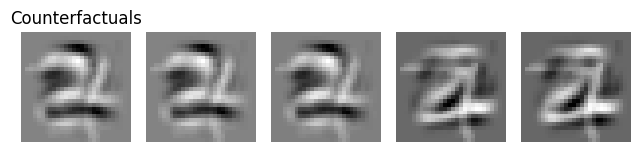

In [ ]:
# Plots each counterfactual instance from above
# Invoking inverse transforms

fig, axes = plt.subplots(1, 5)
axes[0].set_title('Counterfactuals')
for i, ax in enumerate(axes.flat):
  x_prime_pca = np.array(cf_getter.cf_examples_list[0].final_cfs_df.iloc[i, :-1]).reshape(1, -1)
  x_prime_std = pca_model.inverse_transform(x_prime_pca)
  x_prime = stdscaler.inverse_transform(x_prime_std)
  ax.imshow(x_prime.reshape((28, 28)), cmap='gray')
  ax.axis('off')
plt.tight_layout()

Let's recap what we've accomplished. We successfully:

1. Reduced input dimensionality significantly
2. Trained a purely unsupervised anomaly detection model in a corrupted dataset with severe class imbalance
3. Generated counterfactual instances for an anomaly to ascertain which changes to the PC space would produce an inlier sample

Lasting questions:
What do you observe in the counterfactual instances' PC values? Compare them to the original instance's PC values.

What do you observe in the visualization of the counterfactuals? What visual elements are changed to produce the inlier samples?

Does this method work as well in the reverse direction, i.e., generating counterfactual examples of the anomaly digit given an inlier query instance? Why/why not?

# LIME: Locally Interpretable Model-Agnostic Explanations

We will continue to examine the query instance from above using LIME. While we were able to witness firsthand how sparse changes to the PC features were useful to generate counterfactuals, it is still unclear which variables are contributing to the anomaly detection itself.

This is where LIME is useful: we can employ LIME to create a locally interpretable model and analyze the feature contributions to this specific prediction. With just a few lines of code on Python using the lime package, we can gain an understanding on local feature importance, perturb our data sample, and even generate a LIME-informed counterfactual example.

<b>Important: the visualizations here will look better with a light background theme for Google Colab. To adjust the theme, go to Tools > Settings > Theme (light). </b>

In [ ]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(x_pca, feature_names=feature_names, discretize_continuous=True)
local_exp = lime_explainer.explain_instance(x_pca[query_idx], lr.predict_proba, num_features=20)
local_exp.show_in_notebook(show_table=True, show_all=True)
# ignore feature names warning

X does not have valid feature names, but LogisticRegressionCV was fitted with feature names


In [ ]:
# make a copy of the original query instance
perturbed_x_pca = x_pca[query_idx].copy()
print('Original Sample Class Probabilities:', lr.predict_proba(perturbed_x_pca.reshape(1,-1)))

# perturb sample according to LIME
# feel free to change this perturbed sample
perturbed_x_pca[8] = -5 # changing PC_9
print('Perturbed Sample Class Possibilities:', lr.predict_proba(perturbed_x_pca.reshape(1,-1)))

local_exp_perturbed = lime_explainer.explain_instance(perturbed_x_pca, lr.predict_proba, num_features=20)
local_exp_perturbed.show_in_notebook(show_table=True, show_all=True)

Original Sample Class Probabilities: [[3.75255382e-14 1.00000000e+00]]
Perturbed Sample Class Possibilities: [[1.03587619e-06 9.99998964e-01]]


X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
X does not have valid feature names, but LogisticRegressionCV was fitted with feature names


Now let's visualize both samples: the original, and the LIME-informed perturbed sample.

Text(0.5, 1.0, 'Perturbed Input')

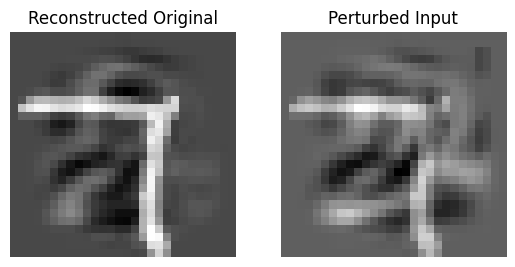

In [ ]:
fig, ax = plt.subplots(1,2)

# plot original sample
ax[0].imshow(query_reconstructed, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Reconstructed Original')

# using inverse transforms again
perturbed_x_std = pca_model.inverse_transform(perturbed_x_pca.reshape(1,-1))
perturbed_x = stdscaler.inverse_transform(perturbed_x_std.reshape(1,-1))

# plot perturbed sample
ax[1].imshow(perturbed_x.reshape((28, 28)), cmap='gray')
ax[1].axis('off')
ax[1].set_title('Perturbed Input')

# SHAP: SHapley Additive exPlanations
Now that we have some intuition on how the principal component variables are influencing anomaly detection, can we obtain a more global understanding on their contributions?

The shap package on Python is very popular for giving us additive explanations (approximations of the Shapley value from game theory). However, as you are about to find out, it is quite computationally expensive to obtain these model-agnostic explanations.

In [ ]:
# This cell will take a few minutes to run
shap_explainer = shap.Explainer(lr.predict_proba, pca_df)

# shap_values is (n x p x c) with n samples, p features, and c classes
# because we are using the predict_proba method, we are computing the SHAP contributions for both classes
shap_values = shap_explainer(pca_df)

shap_values_pos = shap_values[:,:,1] # SHAP values for the positive (anomaly) class

Permutation explainer: 2010it [02:23, 13.42it/s]


We will conclude our demo with the beeswarm plot: one of the the most information-dense XAI visualization tools currently available with present techniques. Let's summarize how you read this plot:

1. The features on the y-axis are ranked by mean absolute SHAP value (i.e., greatest overall influence to the model's output), with the most impactful features on top.
2. Each point on the x-axis represents the SHAP contribution for a single data sample's feature value.
3. Each "row" then represents the distribution of SHAP values for that feature, in which vertical stacking indicates a large concentration of SHAP values.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


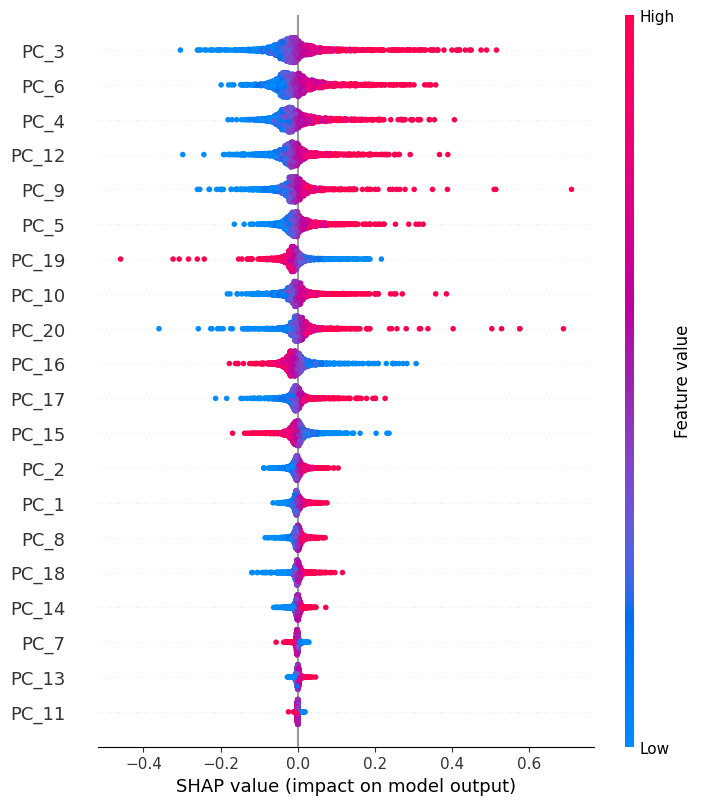

In [ ]:
# Beeswarm plot of the SHAP values for the positive class
shap.plots.beeswarm(shap_values_pos, max_display=20)

Some remaining questions to consider:
1. Which features are contributing most to anomaly detection? Were these the features you were expecting?
2. How do these feature explanations compare with the LIME method? Compare the SHAP contributions of our query instance to the output from LIME.
3. What are the "units" of SHAP values? What is the interpretation of adding them together, along with the estimated base values?

You have made it to the end of this notebook! Please feel free to experiment with this code. I hope you have found it helpful to demonstrate how you can use XAI methods for research purposes! If you have any questions on the material on this notebook or the accompanying slides, please feel free to contact me at cohenyo@umich.edu.